# Импорты

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Чтение данных

Считаем данные и подготовим их к дальнейшему анализу

In [2]:
df = pd.read_csv('accepted_2007_to_2018Q4.csv')
# df.head()

/var/folders/dm/ltzh8my50bvc6cdr0_wggrjr0000gq/T/ipykernel_46314/1338807228.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('accepted_2007_to_2018Q4.csv')


In [3]:
with pd.option_context('display.max_columns',None):
    display(df.head())
df.info()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


# Чистка данных

Почистим данные: столбцы со всеми уникальными значениями можем сразу выкинуть, так как всё уже отображено в sub_grade

In [4]:
df = df.drop(['id','policy_code','out_prncp',
              'out_prncp_inv','url','pymnt_plan',
              'hardship_flag','grade'],
             axis=1)

Столбцы с слишком большим количеством нулевых значений отбрасываются. Чтобы упростить задачу классификации, столбцы должны быть заполнены хотя бы на 90%.

In [5]:
percent = df.isnull().sum() / len(df)
nan_cols = percent.iloc[np.where(np.array(percent) > 0.1)].index
print(len(nan_cols), "- удалено")


59 - удалено


In [6]:
df = df.drop(nan_cols, axis=1)

# Анализ категориальных признаков

Посмотрим на `loan_status`

<AxesSubplot:xlabel='count', ylabel='loan_status'>

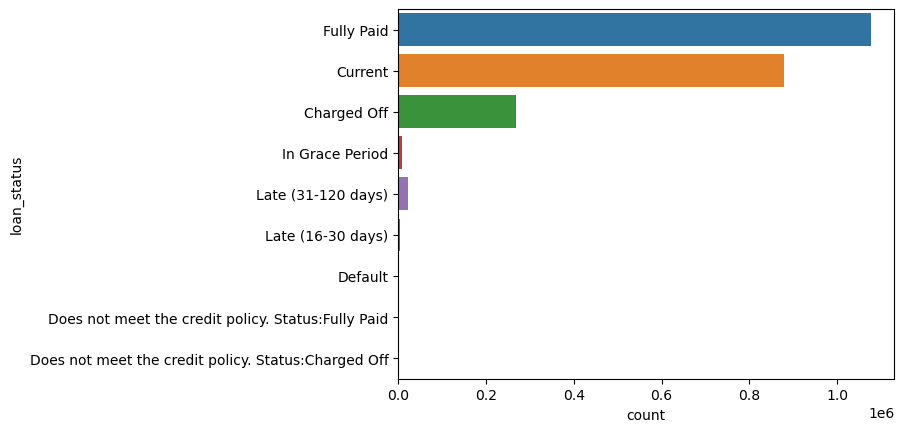

In [8]:
sns.countplot(y='loan_status', data=df)

Нас интересуют только просроченные `Charged Off` и полностью погашенные `Fully Paid` кредиты. Собственно, установим 0 и 1, соответсвенно, остальное - выкинем

In [9]:
df = df[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off')]
df['label'] = df.apply(lambda r: 1 if r['loan_status'] == 'Fully Paid' else 0, axis=1)
df = df.drop('loan_status', axis=1)

In [10]:
# Категориальные признаки

with pd.option_context('display.max_rows',None):
    display(df.describe(include=np.object).transpose())

/var/folders/dm/ltzh8my50bvc6cdr0_wggrjr0000gq/T/ipykernel_46314/2335944267.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  display(df.describe(include=np.object).transpose())


,count,unique,top,freq
term,1345310,2,36 months,1020743
sub_grade,1345310,35,C1,85494
emp_title,1259525,378353,Teacher,21268
emp_length,1266799,11,10+ years,442199
home_ownership,1345310,6,MORTGAGE,665579
verification_status,1345310,3,Source Verified,521273
issue_d,1345310,139,Mar-2016,48937
purpose,1345310,14,debt_consolidation,780321
title,1328651,61682,Debt consolidation,660960
zip_code,1345309,943,945xx,15005


Преобразуем все даты в числовые.

In [11]:
#'issue_d'
date_fields = ['issue_d','earliest_cr_line',
               'last_pymnt_d','last_credit_pull_d']

for col in date_fields:  
    df[col] = pd.to_datetime(df[col]) 
    df[col + '_month'] = df[col].dt.month
    df[col + '_year'] = df[col].dt.year

df = df.drop(date_fields, axis=1)

Поля `emp_title` и `title` содержат слишком много различных значений, сохраним только те, которые чаще всего встречаются

In [12]:
per = 0.01

vc = df['title'].value_counts()
titles = vc.iloc[np.where(np.array(vc) > per * len(df))].index
df['title'] = df.apply(lambda r: r['title'] if r['title'] in titles else 'Other title',axis=1)

In [13]:
vc = df['emp_title'].value_counts()
titles = vc.iloc[np.where(np.array(vc) > per * len(df))].index
df['emp_title'] = df.apply(lambda r: r['emp_title'] if r['emp_title'] in titles else 'Other title',axis=1)

In [14]:
# df

<AxesSubplot:>

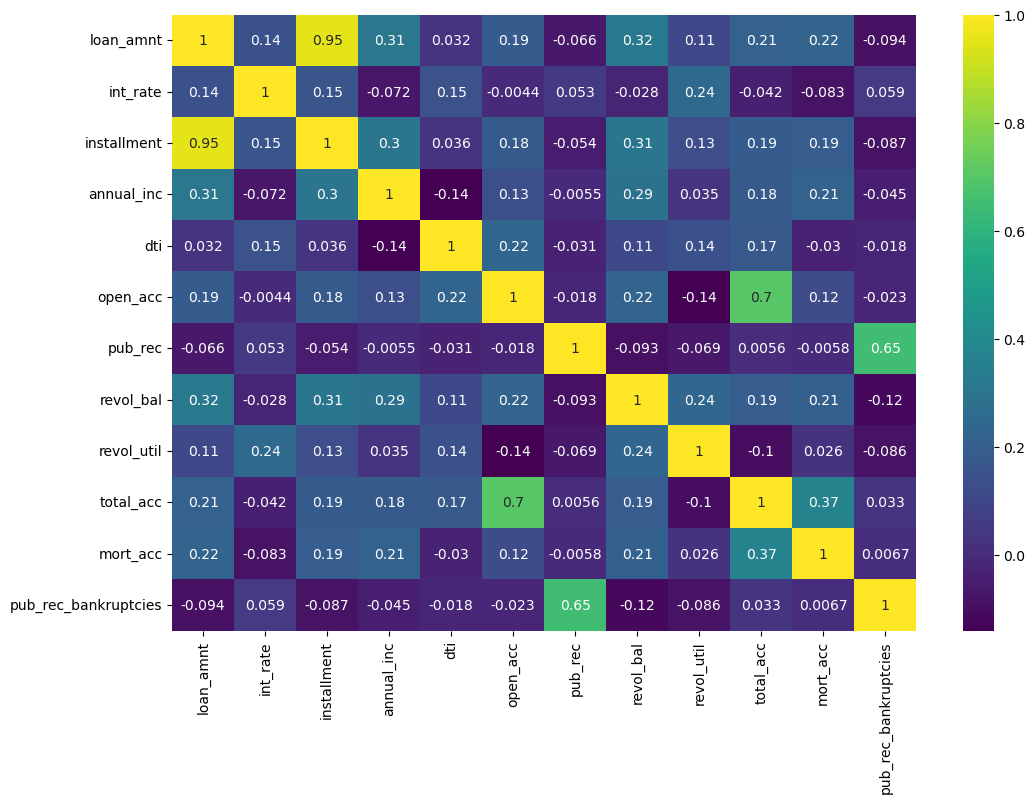

In [16]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

Воспользуемся one-hot 

In [14]:
cat = df.select_dtypes(include=['object']).columns
df[cat] = df[cat].fillna(value='Missing')
df_cat = pd.get_dummies(data=df[cat])

Удалим наименее часто встречающие строки, как и `title`

In [15]:
print("Total # categorical columns: ", len(df_cat.columns))
df_cat = df_cat.drop([col for col, cnt in df_cat.sum().iteritems() if cnt < per * len(df_cat)], axis=1)
print("Reduced # categorical columns: ", len(df_cat.columns))

Total # categorical columns:  1086
Reduced # categorical columns:  102


# Анализ числовых данных

Перейдем к числовым признакам

In [16]:
with pd.option_context('display.max_rows',None):
    display(df.describe().transpose().apply(lambda s: s.apply('{0:.5f}'.format)))

,count,mean,std,min,25%,50%,75%,max
loan_amnt,1345310.00000,14419.97201,8717.05079,500.00000,8000.00000,12000.00000,20000.00000,40000.00000
funded_amnt,1345310.00000,14411.55663,8713.11791,500.00000,8000.00000,12000.00000,20000.00000,40000.00000
funded_amnt_inv,1345310.00000,14389.14160,8715.49399,0.00000,7875.00000,12000.00000,20000.00000,40000.00000
int_rate,1345310.00000,13.23962,4.76872,5.31000,9.75000,12.74000,15.99000,30.99000
installment,1345310.00000,438.07553,261.51260,4.93000,248.48000,375.43000,580.73000,1719.83000
annual_inc,1345310.00000,76247.63641,69925.09843,0.00000,45780.00000,65000.00000,90000.00000,10999200.00000
dti,1344936.00000,18.28267,11.16045,-1.00000,11.79000,17.61000,24.06000,999.00000
delinq_2yrs,1345310.00000,0.31779,0.87799,0.00000,0.00000,0.00000,0.00000,39.00000
fico_range_low,1345310.00000,696.18504,31.85251,625.00000,670.00000,690.00000,710.00000,845.00000
fico_range_high,1345310.00000,700.18518,31.85316,629.00000,674.00000,694.00000,714.00000,850.00000


In [17]:
df = df.drop(cat,axis=1)
df = pd.concat([df,df_cat], axis=1)

In [18]:
with pd.option_context('display.max_columns',None):
    display(df.head())
df.info()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,label,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year,term_ 36 months,term_ 60 months,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,emp_title_Manager,emp_title_Other title,emp_title_Teacher,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_Missing,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_medical,purpose_other,purpose_small_business,title_Credit card refinancing,title_Debt Consolidation,title_Debt consolidation,title_Home improvement,title_Major purchase,title_Medical expenses,title_Other,title_Other title,zip_code_112xx,zip_code_750xx,zip_code_945xx,addr_state_AL,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_FL,addr_state_GA,addr_state_IL,addr_state_IN,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_NC,addr_state_NJ,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OR,addr_state_PA,addr_state_SC,addr_state_TN,addr_state_TX,addr_state_VA,addr_state_WA,addr_state_WI,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,disbursement_method_Cash,debt_settlement_flag_N,debt_settlement_flag_Y
0,3600.0,3600.0,3600.0,13.99,123.03,55000.0,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,122.67,564.0,560.0,0.0,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,1,12,2015,8,2003,1.0,2019.0,3.0,2019.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0
1,24700.0,24700.0,24700.0,11.99,820.28,65000.0,16.06,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,926.35,699.0,695.0,0.0,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,1,12,2015,12,1999,6.0,2016.0,3.0,2019.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Columns: 176 entries, loan_amnt to debt_settlement_flag_Y
dtypes: float64(69), int64(5), uint8(102)
memory usage: 900.7 MB


# Итоговый датасет

In [19]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,addr_state_VA,addr_state_WA,addr_state_WI,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,disbursement_method_Cash,debt_settlement_flag_N,debt_settlement_flag_Y
0,3600.0,3600.0,3600.0,13.99,123.03,55000.0,5.91,0.0,675.0,679.0,...,0,0,0,0,1,1,0,1,1,0
1,24700.0,24700.0,24700.0,11.99,820.28,65000.0,16.06,1.0,715.0,719.0,...,0,0,0,0,1,1,0,1,1,0
2,20000.0,20000.0,20000.0,10.78,432.66,63000.0,10.78,0.0,695.0,699.0,...,0,0,0,0,1,0,1,1,1,0
4,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,695.0,699.0,...,0,0,0,0,1,1,0,1,1,0
5,11950.0,11950.0,11950.0,13.44,405.18,34000.0,10.20,0.0,690.0,694.0,...,0,0,0,0,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,18000.0,18000.0,18000.0,9.49,377.95,130000.0,20.59,0.0,735.0,739.0,...,0,0,0,1,0,1,0,1,1,0
2260690,29400.0,29400.0,29400.0,13.99,683.94,180792.0,22.03,0.0,705.0,709.0,...,0,0,0,1,0,1,0,1,1,0
2260691,32000.0,32000.0,32000.0,14.49,752.74,157000.0,10.34,0.0,735.0,739.0,...,0,0,0,1,0,1,0,1,1,0
2260692,16000.0,16000.0,16000.0,12.79,362.34,150000.0,12.25,0.0,665.0,669.0,...,0,0,0,1,0,1,0,1,1,0


# Моделирование

Признаки с наибольшей корреляцией

<AxesSubplot:>

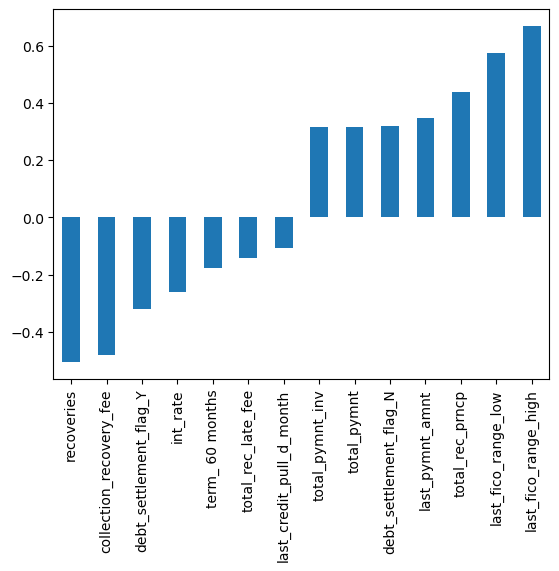

In [21]:
corrs = df.corr()['label'].sort_values(ascending=True).drop('label')
pd.concat([corrs.iloc[:7],corrs.iloc[-7:]],axis=0).plot.bar()

Разделяем данные 

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix,precision_score,recall_score,precision_recall_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Для оценки точности модели мы применяем процесс разделения данных на две части: тренировочную и тестовую выборки. Это позволяет нам оценить производительность модели на независимых данных и проверить ее способность обобщать знания на новые примеры.

Для выполнения этого разделения мы используем функцию train_test_split, которая принимает в качестве аргументов матрицу признаков X и вектор целевой переменной y. Затем данные разделяются на две группы: тренировочную выборку (80% данных) и тестовую выборку (20% данных).

In [23]:
X = df.drop('label',axis=1).values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

Выполним нормализацию данных с использованием MinMaxScaler и обработка отсутствующих значений с помощью np.nan_to_num.

Нормализация данных с помощью MinMaxScaler приводит значения признаков к диапазону от 0 до 1. Это полезно, когда значения признаков имеют разный масштаб, и мы хотим привести их к одному общему масштабу. Это также может быть полезно для некоторых алгоритмов машинного обучения, которые чувствительны к различным масштабам признаков.

Обработка отсутствующих значений с помощью np.nan_to_num используется для замены всех пропущенных значений (NaN) в данных на нулевые значения. Это может быть необходимо для обеспечения корректной работы некоторых алгоритмов машинного обучения, которые не могут обрабатывать отсутствующие значения.


In [24]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# Модель случайного леса


Модель случайного леса


In [42]:
from sklearn.model_selection import cross_val_score

# определение модели
model = RandomForestRegressor(n_estimators=100, random_state=42)

# проведение кросс-валидации на 5 фолдах
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# вывод результатов
print("Cross-validation scores: ", scores)
print("Mean squared error: ", -scores.mean())


Cross-validation scores:  [-0.00561514 -0.00095901 -0.00329544 -0.00311084 -0.00134374]
Mean squared error:  0.00286483643175179


Результаты кросс-валидации говорят о том, что модель случайного леса с количеством деревьев (n_estimators) равным 100 и random_state=42 демонстрирует среднеквадратическую ошибку (MSE) в размере 0.00286 на кросс-валидации с 5 фолдами. 

Отрицательное значение означает, что значение MSE было умножено на -1 для удобства интерпретации. В данном случае чем меньше значение MSE, тем лучше качество модели. 

Эти значения могут быть использованы для сравнения с другими моделями.